In [6]:
import os, sys
import traceback
from Module.allo_chain import *
from Module.count import *
from Module.denoise import *
from Module.network import *
from Module.IO_stat import *

plt.style.use('classic')
%matplotlib inline

In [7]:
def data_list(path):
    data_load = []
    for i in os.listdir(path):
        j = i.split('.')
        if j[-1] == 'txt':
            data_load.append(i)
    return data_load

In [8]:
data_path = './data' #The path of 'data' folder

Text_path = data_path + '/Text/'                   #put your text here
#----------------------------------------------------------------------
Nsyl_path = data_path + '/N_syl/'                  #the output folder of N-syl distribution plot
Chain_path = data_path + '/Chain/'                 #the output folder of chain-rank plot
Allo_path = data_path + '/Allocation/'             #the output folder of allocation-rank plot
RRD_path = data_path + '/RRD/'                     #the output folder of RRD plot
FRD_path = data_path + '/FRD/'                     #the output folder of FRD plot
Geo_path = data_path + '/Geometric seq/'           #the output folder of geometric sequence plot
SC_path = data_path + '/SC/'                       #the output document of rg plot and SC value
fitting_path = data_path + '/fitting/'             #the output document of scaling lines fitting
net_block_path = data_path + '/network block/'     #the output document of network analysis of word
net_compo_path = data_path + '/network component/' #the output document of network analysis of syllagram
para_path = data_path + '/parameter/'              #the output document of GLC parameters

#----------------------------------------------------------------------
Big_path = data_path + '/Statistical result/'      #the output folder of all statistical data in execl


data_load = data_list(Text_path)
Text_load = [Text_path + i for i in data_load]
for i in data_load:
    print(i)

2-gram-Expoonential.txt
Excerpts from Frog.txt
2-gram-Gaussian.txt


In [9]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)

def main():
    error_list = []
    #-------------------check if folders exist-----------------------------
    PATH = [Nsyl_path, Chain_path, Allo_path, RRD_path, FRD_path, Geo_path, SC_path,
            fitting_path, net_block_path, net_compo_path, para_path, Big_path]
    for P in PATH:
        try:           
            os.makedirs(P)  #create the folder
        except:
            print('***The folder "%s" already exist.' % P)
    #----------------------------------------------------------------------
    for Q in range(len(data_load)):
        try:
            filename = data_load[Q]
            name = filename.split('.txt')[0]
            big, syl, word, longest = info(Text_load[Q], encode)
            count_allo(word, syl)
            print('Successfully count allocation and chain!' + '(%s)' % filename)
            write_to_excel(big, word, syl, Big_path + name)
            #--------------plot N-syl plot
            FORMAT = 'png' #the format of your picture
            density = True
            Path = Nsyl_path
            
            N_syl_dist(name, big, longest, density, FORMAT, Path)
            #--------------plot geometric_sequence
            V, H = geometric_sequence(word, syl)
            max_range = 50 #the number of elements in the sequence you want to know
            x = 'H'
            FORMAT = 'png' #the format of your picture
            shift = 'N' #If you don't want to measure shift, just assign shift != 'T'.
            Path = Geo_path
            
            RH = which_plot(name, V, H, x, max_range, shift, FORMAT, Path)
            #--------------plot FRD plot
            FORMAT = 'png' #the format of your picture
            #auto positioning when (x_pos, y_pos)=(0, 0)
            x_pos = 0
            y_pos = 0
            Path = FRD_path

            FRD_word = FRD_plot(name, word, syl, x_pos, y_pos, FORMAT, Path)
            Zipf = FRD_word['ab'] #(a, b) of a*x ^-b
            #--------------plot RRD plot
            need_line = 'Y'
            number_of_lines = 4
            Color = '#ff0000'
            FORMAT = 'pdf' #the format of your picture
            Path = RRD_path

            RRD_coordinate = draw_RRD_plot(big, word, syl, longest, name, V, H,
                           need_line, number_of_lines, Color, FORMAT, Path)
            #--------------plot allocation-rank plot
            FORMAT = 'png' #the format of your picture
            x_pos = 0 #auto positioning = 0; otherwise change the value you want
            y_pos = 0 #auto positioning = 0; otherwise change the value you want
            Path = Allo_path

            Allo_fit = Allo_plot(name, syl, x_pos, y_pos, FORMAT, Path)
            #--------------plot chain-rank plot
            FORMAT = 'png' #the format of your picture
            x_pos = 0 #auto positioning = 0; otherwise change the value you want
            y_pos = 0 #auto positioning = 0; otherwise change the value you want
            Path = Chain_path

            Chain_fit = Chain_plot(name, word, x_pos, y_pos, FORMAT, Path)
            #--------------calculate SC and fitting scaling lines
            FORMAT = 'png' #the format of your picture
            L = 4
            toler = 50
            num_window = 101
            num_section = 2
            delta = 0.15
            percent = 0.05

            g, glu = plot_g(L, V, H, big, name, longest, toler, num_window, num_section, delta, percent)
            Rg = rg(name, g, FORMAT, SC_path)
            
            fit_para_best = fit_with_cut(glu, Rg[0], V, H, Zipf, name, FORMAT, fitting_path)
            #--------------Network analysis
            graph_word, graph_syl = build_edge(RRD_coordinate)
            G_word, cluster_word, word_degree_sequence = graph_word[0], graph_word[1], graph_word[2]
            G_syl, cluster_syl, syl_degree_sequence = graph_syl[0], graph_syl[1], graph_syl[2]            
            FORMAT = 'png'
            
            Path = net_block_path
            plot_degree_block(name, word_degree_sequence, FORMAT, Path)
            
            Path = net_compo_path
            degree_component = plot_degree_compo(name, syl_degree_sequence, FORMAT, Path)
            #--------------Record all GLC parameters and RRD points
            data_set = {}
            coordinate_set = {}
            
            data_set['FRD_word'] = FRD_word
            coordinate_set['RRD_coordinate'] = RRD_coordinate
            data_set['Allo_fit'] = Allo_fit
            data_set['Chain_fit'] = Chain_fit
            coordinate_set['glu'] = glu
            data_set['Rg'] = Rg
            data_set['fit_para_best'] = fit_para_best
            data_set['degree_component'] = degree_component
            
            #save para_ (GLC paras) and coor_ (RRD points)
            Path = para_path
            para_filename = 'para_' + filename
            save_parameters(para_filename, data_set, Path)            
            coor_filename = 'coor_' + filename
            save_parameters(coor_filename, coordinate_set, Path)
            
            print('Successfully run all!' + '(%s)' % filename)
        #--------------add filename to error_list when error      
        except Exception as exc:
            traceback.print_exc()
            error_list.append(data_load[Q])
            print('')
    if error_list != []:
        print('The following file get error when running:')
        for i in error_list:
            print(i)

***The folder "./data/N_syl/" already exist.
***The folder "./data/Chain/" already exist.
***The folder "./data/Allocation/" already exist.
***The folder "./data/RRD/" already exist.
***The folder "./data/FRD/" already exist.
***The folder "./data/Geometric seq/" already exist.
***The folder "./data/SC/" already exist.
***The folder "./data/fitting/" already exist.
***The folder "./data/network block/" already exist.
***The folder "./data/network component/" already exist.
***The folder "./data/parameter/" already exist.
***The folder "./data/Statistical result/" already exist.
read file successfully!
Successfully count word freqency!(./data/Text/2-gram-Expoonential.txt)
Successfully count syl freqency!
Successfully build data frames!
Successfully count allocation and chain!(2-gram-Expoonential.txt)
the (4, 5) rectangle has no point.
the (1, 2) rectangle has no point.
the (4, 5) rectangle has no point.
the (2, 4) rectangle has no point.
the (3, 5) rectangle has no point.
the (5, 7) rec

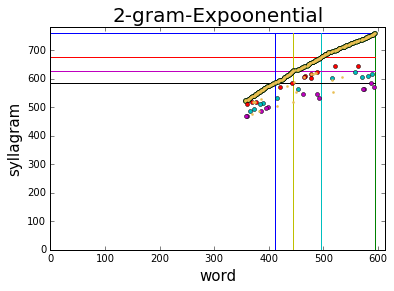

/Users/lab/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lab/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lab/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lab/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lab/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lab/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarr

C < 0.8: g3/g2, 0.000000
C < 0.8: g4/g3, 0.000000


Traceback (most recent call last):
  File "<ipython-input-9-5f323e7501ed>", line 82, in main
    fit_para_best = fit_with_cut(glu, Rg[0], V, H, Zipf, name, FORMAT, fitting_path)
  File "/Users/lab/Downloads/Genetics-Linguistics-Correspondence/Scaling-linguistics/Mandarin Chinese/Module/denoise.py", line 831, in fit_with_cut
    fit_para = scaling_fit(D, Rg_0, V, H, Zipf, name, FORMAT, Path)
  File "/Users/lab/Downloads/Genetics-Linguistics-Correspondence/Scaling-linguistics/Mandarin Chinese/Module/denoise.py", line 707, in scaling_fit
    popt, pcov = curve_fit(fun_theory, data[gk][0], data[gk][1], q0, bounds = (0, [np.inf, np.inf]))
  File "/Users/lab/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 795, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/Users/lab/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_lsq/least_squares.py", line 824, in least_squares
    raise ValueError("Residuals are not finite


read file successfully!
Successfully count word freqency!(./data/Text/Excerpts from Frog.txt)
Successfully count syl freqency!
Successfully build data frames!
Successfully count allocation and chain!(Excerpts from Frog.txt)
the (5, 6) rectangle has no point.
the (5, 7) rectangle has no point.
the (4, 7) rectangle has no point.
the (4, 7) rectangle has no point.
the (5, 8) rectangle has no point.


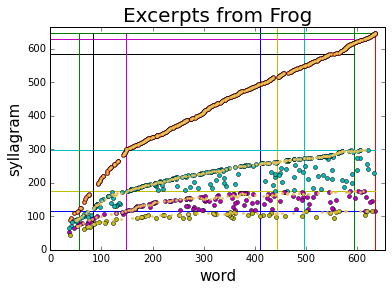

C < 0.8: g3/g2, 0.544554
C < 0.8: g4/g3, 0.247525
fitting range = [159, 636]
Successfully run all!(Excerpts from Frog.txt)
read file successfully!
Successfully count word freqency!(./data/Text/2-gram-Gaussian.txt)
Successfully count syl freqency!
Successfully build data frames!
Successfully count allocation and chain!(2-gram-Gaussian.txt)


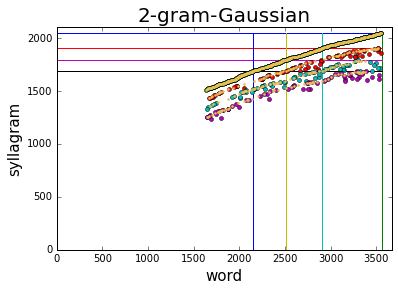

C < 0.8: g3/g2, 0.356436
C < 0.8: g4/g3, 0.336634
fitting range = [890, 3560]
Successfully run all!(2-gram-Gaussian.txt)
The following file get error when running:
2-gram-Expoonential.txt


In [10]:
main()